## **Random Forest Retrievals**

*Chloe Fisher* (chloe.fisher@unibe.ch)

This notebook covers how to run a Random Forest retrieval on low-resolution data. The example uses HST WFC3 data for WASP-12 b (Kreidberg et al. 2015).

In [ ]:
! git clone https://github.com/exoclime/HELA.git

Cloning into 'HELA'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 209 (delta 1), reused 1 (delta 0), pack-reused 200
Receiving objects: 100% (209/209), 12.76 MiB | 25.13 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First let's take a look at the data. This is the transmission spectrum of WASP-12 b from WFC3, reduced and ready for retrieval. 

Text(0, 0.5, 'Transit Depth $(R_p/R_*)^2$')

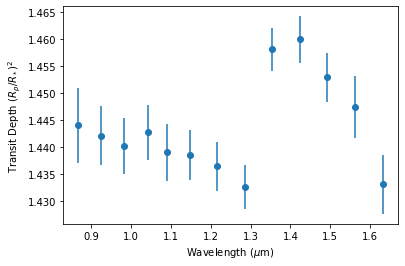

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

wavelength = np.load('HELA/example_dataset/wavelength.npy')
data = np.load('HELA/example_dataset/WASP12b.npy')[0]
error = np.load('HELA/example_dataset/error_bars.npy')

fig, ax = plt.subplots()
ax.errorbar(wavelength, data, yerr=error, fmt='o')
ax.set_xlabel(r'Wavelength ($\mu$m)')
ax.set_ylabel(r'Transit Depth $(R_p/R_*)^2$')

This spectrum is what we want the forest to retrieve. So first, we need to train the forest. This involves creating a training set of spectra that the forest can learn from. This step is the bottle neck in the process, so we have a pre-generated training set ready to go. For this, we used WASP-12 b's parameters (stellar and planetary radius and gravity), and varied 5 atmospheric parameters that we want to retrieve. In this case we used temperature, abundances of H2O, HCN, and NH3, and a grey cloud opacity. We used a simplified analytical model of the transit depth to create a set of 100,000 spectra with different atmospheric parameters. This is then split into 80,000 training spectra and 20,000 testing spectra. The training set itself is just a numpy array, with each row containing the 13 spectral points, followed by the 5 atmospheric parameters. Here we can plot the first 10 spectra in the training set.

Text(0, 0.5, 'Transit Depth $(R_p/R_*)^2$')

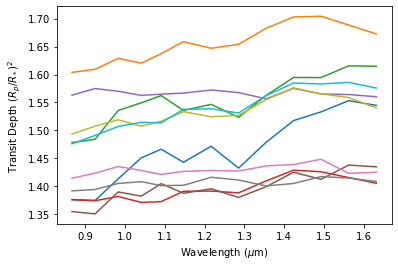

In [ ]:
training_set = np.load('HELA/example_dataset/training.npy')

fig, ax = plt.subplots()
for i in range(10):
  ax.plot(wavelength, training_set[i, :13])
ax.set_xlabel(r'Wavelength ($\mu$m)')
ax.set_ylabel(r'Transit Depth $(R_p/R_*)^2$')

These spectra all have different atmospheric parameters, leading to these different shapes and offsets. 

Now we're ready to use the forest. First, double click on the example_dataset.json file in the example_dataset/ folder. This is the information the forest needs to read the training and testing sets, and create plots. Note: the "num_features" tells the forest how to split the data into the spectral points and the retrieval parameters. 

The forest has two settings: train and predict. Before using each one, you can use the help feature to check the required and optional arguments.

In [ ]:
% cd HELA/

! python3 rfretrieval.py train -h

/content/HELA
usage: rfretrieval.py train [-h] [--num-trees NUM_TREES] [--num-jobs NUM_JOBS]
                            [--feature-importance]
                            training_dataset model_path

positional arguments:
  training_dataset      JSON file with the training dataset description
  model_path            path where the trained model will be saved

optional arguments:
  -h, --help            show this help message and exit
  --num-trees NUM_TREES
                        number of trees in the forest
  --num-jobs NUM_JOBS   number of parallel jobs for fitting the random forest
  --feature-importance  compute feature importances after training


Now we can train the forest. This will take about 5 minutes. 

In [ ]:
! python3 rfretrieval.py train example_dataset/example_dataset.json example_model/

2021-08-19 09:31:48,838 [__main__] Loading dataset 'example_dataset/example_dataset.json'...
2021-08-19 09:31:48,854 [__main__] Training model...
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   11.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   54.1s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:  4.8min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:   10.7s
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:   13.6s finished
2021-08-19 09:37:09,121 [__main__] Saving model to 'example_mo

The forest has been trained and tested, and the results of the testing stage are saved in example_model/predicted_vs_real.pdf. You can download and view this plot to see how the forest performs over the range of parameters. 

The trained forest is saved in the example_model/ folder as model.pkl. You can now use this to predict on the real spectrum, or any individual spectrum for which you want the full retrieval. 

In [ ]:
! python3 rfretrieval.py predict -h

usage: rfretrieval.py predict [-h] [--plot-posterior]
                              model_path data_file output_path

positional arguments:
  model_path        path to the trained model
  data_file         NPY file with the data for the prediction
  output_path       path to write the results of the prediction

optional arguments:
  -h, --help        show this help message and exit
  --plot-posterior  plot and save the scatter matrix of the posterior
                    distribution


Use the --plot-posterior argument to plot the posterior for the retrieval.

In [ ]:
! python3 rfretrieval.py predict example_model/ example_dataset/WASP12b.npy example_model/ --plot-posterior

2021-08-19 09:44:30,240 [__main__] Loading random forest from 'example_model/model.pkl'...
2021-08-19 09:44:42,874 [__main__] Loading data from 'example_dataset/WASP12b.npy'...
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:    0.1s finished
Prediction for $T (K)$: 892 [+397 -147]
Prediction for H$_2$O: -2.3 [+1.54 -3.16]
Prediction for HCN: -7.22 [+3.74 -3.89]
Prediction for NH$_3$: -8.68 [+3.89 -3.57]
Prediction for $\kappa_0$: -2.34 [+1.33 -1.42]
2021-08-19 09:44:43,246 [__main__] Plotting the posterior matrix...
100% 25/25 [01:15<00:00,  3.02s/it]
2021-08-19 09:45:59,242 [__main__] Saving the figure....
2021-08-19 09:46:05,161 [__main__] Done.


View the posterior_matrix.pdf in example_model/. This is effectively the standard cornerplot you get from a normal retrieval, plus the top right panels which show the individual predictions from each tree.


The forest can also provide an information content analysis, known as the feature importance. This will determine which spectral points were most importance for determining each parameter when training the forest. Here you can run it, but it will take about 30 minutes. 

In [ ]:
! python3 rfretrieval.py train example_dataset/example_dataset.json example_model/ --feature-importance

2021-08-19 10:09:50,188 [__main__] Loading dataset 'example_dataset/example_dataset.json'...
2021-08-19 10:09:50,217 [__main__] Training model...
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   11.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   55.7s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:  4.9min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:   10.0s
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:   12.6s finished
2021-08-19 10:15:14,424 [__main__] Saving model to 'example_mo

View the feature importance plot in example_model/feature_importances.pdf.